In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
enable_wandb = True
if enable_wandb:
    import wandb
    wandb.login()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: niklas-kemper. Use `wandb login --relogin` to force relogin


In [3]:
from torch_geometric.datasets import TUDataset

In [4]:
from substructures import get_rings, get_substructure_edge_index, get_node_counts
import torch
def pre_transform(graph):
    triangles = get_rings(graph.edge_index, max_k =3)
    squares = get_rings(graph.edge_index, min_k = 4, max_k = 4)
    substructures_edge_index = [get_substructure_edge_index(substructure) for substructure in [triangles, squares]]
    return graph.update({"substructures_edge_index": substructures_edge_index, "y": get_node_counts(triangles, graph.num_nodes), "x": torch.zeros((graph.num_nodes,1))})

In [5]:
DATASET_NAME = "ENZYMES"
dataset = TUDataset(root=f'/tmp/{DATASET_NAME}_node_level', name=DATASET_NAME, pre_transform = pre_transform, use_node_attr= True)

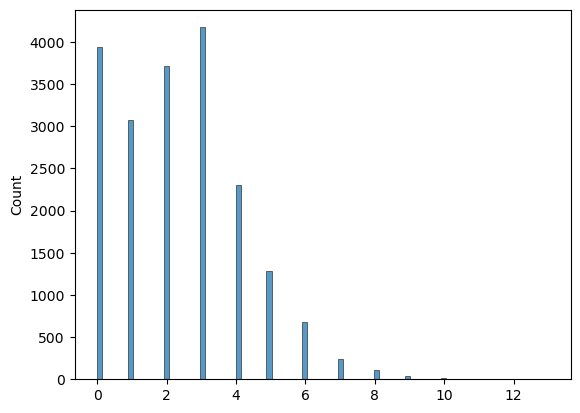

In [6]:
import seaborn as sns
from itertools import chain
sns.histplot(list(map(lambda x: int(x), list(chain(*[graph.y for graph in dataset])))))

In [7]:
from torch_geometric.loader import DataLoader

In [8]:
torch.manual_seed(0)
count_dataset = dataset.shuffle()
train_num = int(len(count_dataset) * 0.6)
val_num = int(len(count_dataset) * 0.2)
train_dataset = count_dataset[:train_num]
val_dataset = count_dataset[train_num:train_num + val_num]
test_dataset = count_dataset[train_num + val_num:]
train_loader = DataLoader(train_dataset, batch_size = 16)
val_loader = DataLoader(val_dataset, batch_size=16)
test_loader = DataLoader(test_dataset, batch_size=16)


In [9]:
hyper = {"lr":0.01, 
         "weight_decay":5e-4, 
         "num_layers":3, 
         "batch_size": 16, 
         "hidden_channels": 16, 
         "substructures": ["triangles", "squares"], 
         "dataset": DATASET_NAME, 
         "target": "triangles", 
         "node_level_predictions": True, 
         "max_epochs": 50}

In [19]:
import simple_model_triangles
model = simple_model_triangles.SimpleSubstructureNeuralNet(hidden_channels=hyper["hidden_channels"], out_channels=1, in_channels = dataset.num_node_features, num_layers=hyper["num_layers"], num_substructures=2)

In [20]:
print(model)

SimpleSubstructureNeuralNet(
  (layers): ModuleList(
    (0): SubstructureLayer(
      (message_neighbor): GINConv(nn=Sequential(
        (0): Linear(in_features=1, out_features=32, bias=True)
        (1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
        (3): Linear(in_features=32, out_features=16, bias=True)
      ))
      (node2substructures): ModuleList(
        (0-1): 2 x Sequential(
          (0): Linear(in_features=16, out_features=32, bias=True)
          (1): ReLU()
          (2): Linear(in_features=32, out_features=16, bias=True)
        )
      )
      (substructures2node): ModuleList(
        (0-1): 2 x Sequential(
          (0): Linear(in_features=16, out_features=32, bias=True)
          (1): ReLU()
          (2): Linear(in_features=32, out_features=16, bias=True)
        )
      )
    )
    (1-2): 2 x SubstructureLayer(
      (message_neighbor): GINConv(nn=Sequential(
        (0): Linear(in_features=16, out_featur

In [21]:
from trainer import GraphNetNodePredictions
from pytorch_lightning.loggers import WandbLogger
from pytorch_lightning import Trainer

wandb_logger = WandbLogger(project='triangle-counting-multiple-datasets', name= "triangle counting with linear attention")
wandb_logger.experiment.config.update(hyper)
wandb_logger.watch(model, log="all")

trainer = Trainer(max_epochs=hyper["max_epochs"], logger= wandb_logger, enable_progress_bar= False, log_every_n_steps=15)
model_lightning = GraphNetNodePredictions(model, lr = hyper["lr"], weight_decay = hyper["weight_decay"])

trainer.fit(model_lightning, train_dataloaders=train_loader, val_dataloaders= val_loader)
wandb.finish()

wandb: logging graph, to disable use `wandb.watch(log_graph=False)`
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name  | Type                        | Params
------------------------------------------------------
0 | model | SimpleSubstructureNeuralNet | 15.8 K
------------------------------------------------------
15.8 K    Trainable params
0         Non-trainable params
15.8 K    Total params
0.063     Total estimated model params size (MB)
/Users/niklas/anaconda3/envs/substructureML/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:432: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/Users/niklas/Documents/Stu

epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
square_attention,█▇▅▅▅▄▄▄▃▃▃▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁
trainer/global_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
training_loss,█▄▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
triangle_attention,▁▂▄▄▄▅▅▅▆▆▆▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇█████
val_acc,▁▅▅▂████████████████████████████████████
val_loss,█▂▃▇▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,49
square_attention,-0.07162
trainer/global_step,1149
training_loss,6e-05
